# Imports

In [141]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline # Used to smoothen out data
import statsmodels.api as sm # Used later to estimate a team's "quality"
import matplotlib.pyplot as plt

# Reading in csvs

In [142]:
MRegularSeasonCompactResults = pd.read_csv('../../data/MRegularSeasonCompactResults.csv')
WRegularSeasonCompactResults = pd.read_csv('../../data/WRegularSeasonCompactResults.csv')
MRegularSeasonDetailedResults = pd.read_csv('../../data/MRegularSeasonDetailedResults.csv')
WRegularSeasonDetailedResults = pd.read_csv('../../data/WRegularSeasonDetailedResults.csv')
MNCAATourneyCompactResults = pd.read_csv('../../data/MNCAATourneyCompactResults.csv')
WNCAATourneyCompactResults = pd.read_csv('../../data/WNCAATourneyCompactResults.csv')
MNCAATourneyDetailedResults = pd.read_csv('../../data/MNCAATourneyDetailedResults.csv') 
WNCAATourneyDetailedResults = pd.read_csv('../../data/WNCAATourneyDetailedResults.csv')
MNCAATourneySeeds = pd.read_csv('../../data/MNCAATourneySeeds.csv')
WNCAATourneySeeds = pd.read_csv('../../data/WNCAATourneySeeds.csv')
MGameCities = pd.read_csv('../../data/MGameCities.csv') 
WGameCities = pd.read_csv('../../data/WGameCities.csv')
MSeasons = pd.read_csv('../../data/MSeasons.csv') 
WSeasons = pd.read_csv('../../data/WSeasons.csv')

# Combining men and women datasets

In [143]:
tourney_results = pd.concat([
    MNCAATourneyDetailedResults, WNCAATourneyDetailedResults
], ignore_index=True)

seeds = pd.concat([
    MNCAATourneySeeds, WNCAATourneySeeds
], ignore_index=True)

regular_results = pd.concat([
    MRegularSeasonDetailedResults, WRegularSeasonDetailedResults
], ignore_index=True)

## Making every game appear twice (from both winner and loser's perspective)

#### Also "one-hot encodes" location (1 = home, -1 = away, 0 = neutral)

In [144]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [145]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

# Feature selection

# BETTER FEATURE ENGINEERING??

In [146]:
features = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

# Computing season averages for each feature in the above array (grouped by season & teamID)

#### Also replacing "T2" with "Opponent" and "T1" with an empty string

In [147]:
funcs = [np.mean]

season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[features].agg(funcs).reset_index()

season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_11206/4129688711.py:3: FutureWarning: The provided callable <function mean at 0x1200e02c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[features].agg(funcs).reset_index()


In [148]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

# Win ratio for every team in the last 14 days of the regular season. 

# CHANGE TO LESS RECENT (20 days, 30 days, etc)??

# TRY FULL SEASON

In [149]:
last30days_stats_T1 = regular_data.loc[regular_data.DayNum>102].reset_index(drop=True)
last30days_stats_T1['win'] = np.where(last30days_stats_T1['PointDiff']>0,1,0)
last30days_stats_T1 = last30days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_30d')

last30days_stats_T2 = regular_data.loc[regular_data.DayNum>102].reset_index(drop=True)
last30days_stats_T2['win'] = np.where(last30days_stats_T2['PointDiff']<0,1,0)
last30days_stats_T2 = last30days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_30d')


In [150]:
tourney_data = pd.merge(tourney_data, last30days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last30days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [151]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])

# Using a logistic regression model to classify teams based on "quality"

In [152]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality


In [153]:
formula = 'win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2010,:], 
                          family=sm.families.Binomial()).fit()

quality = pd.DataFrame(glm.params).reset_index()

glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023)
                         ]).reset_index(drop=True)

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: Runti

In [154]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

# Adding team quality to each team in the tournament data frame

In [155]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [156]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# 45 features ---> definitely need to feature engineer

In [157]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last30days_stats_T1.columns[2:999]) + \
    list(last30days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

print(len(features))
print(features[:10])

45
['T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T1_opponent_FGMmean']


In [158]:
features = (
    list(season_statistics_T1.columns[2:]) + 
    list(season_statistics_T2.columns[2:]) + 
    list(seeds_T1.columns[2:]) + 
    list(seeds_T2.columns[2:]) + 
    list(last30days_stats_T1.columns[2:]) + 
    list(last30days_stats_T2.columns[2:]) + 
    ["Seed_diff"] + 
    ["T1_quality", "T2_quality"]
)

# What the features look like in the dataset

In [159]:
display(tourney_data[features].head(10))
print("\nfeatures shape:", tourney_data[features].shape)

,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,T1_win_ratio_30d,T2_win_ratio_30d,Seed_diff,T1_quality,T2_quality
0,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,...,8.000000,2.600000,1.966667,16,16,0.428571,0.454545,0,NaN,NaN
1,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,...,7.103448,3.655172,4.655172,1,16,0.857143,0.750000,-15,NaN,NaN
2,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,...,7.275862,3.172414,8.689655,10,7,0.428571,0.888889,3,NaN,NaN
3,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,...,6.333333,2.575758,14.909091,11,6,0.900000,0.777778,5,NaN,NaN
4,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,...,7.433333,2.833333,4.400000,8,9,0.500000,0.500000,-1,NaN,NaN
5,29.533333,62.200000,6.066667,15.700000,14.766667,15.633333,15.800000,5.933333,18.400000,24.866667,...,5.483871,2.225806,8.774194,5,12,0.600000,0.750000,-7,NaN,NaN
6,27.366667,60.333333,7.333333,20.600000,13.766667,13.833333,14.033333,8.500000,21.266667,25.066667,...,9.033333,3.066667,1.333333,3,14,0.800000,0.500000,-11,NaN,NaN
7,26.064516,55.451613,7.161290,19.064516,11.935484,15.741935,14.548387,6.806452,18.645161,23.903226,...,4.142857,3.035714,5.821429,9,8,0.714286,0.375000,1,NaN,NaN
8,27.100000,55.800000,7.433333,20.166667,9.733333,18.266667,13.166667,7.000000,19.133333,20.333333,...,5.967742,2.548387,6.677419,4,13,0.800000,1.000000,-9,NaN,NaN
9,30.233333,62.300000,4.800000,14.133333,14.300000,16.733333,14.900000,10.133333,16.700000,24.600000,...,5.000000,2.100000,5.866667,2,15,0.777778,0.777778,-13,NaN,NaN



features shape: (4552, 45)


# Target variable = score difference; features = features from above

In [160]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

# Standardizing input features

In [161]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dtrain = xgb.DMatrix(X_scaled, label=y)

# Loss function (cauchy object)

In [162]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

# Loss function (huber loss)

In [163]:
def huberobj(preds, dtrain):
    labels = dtrain.get_label()
    delta = 1.0  # You can tune this parameter
    x = preds - labels
    grad = np.where(np.abs(x) <= delta, x, delta * np.sign(x))
    hess = np.where(np.abs(x) <= delta, 1, 0)
    return grad, hess


# Model parameters (learning rate, tree size, etc)

# IMPROVE PARAMETERS??

In [164]:
param = {} 

param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 # learning rate --> adjust accordingly 
param['subsample'] = 0.35 ## proprtion of the training data used in each tree
param['colsample_bytree'] = 0.7 ## proportion of features used in each tree
param['num_parallel_tree'] = 10 ## num of trees
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 0 ## making the logs during training very clear 

# Training the model!

# ADD DROPOUT

In [165]:
xgb_cv = [] ## storing the results of each cross-validation run 
repeat_cv = 10 # doing 10 runs of cross-validation (more/less ??)

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj, # specific loss function we defined above (change it??)
          num_boost_round = 3000, # max number of rounds if early stopping doesn't stop it 
          folds = KFold(n_splits = 5, shuffle = True, random_state = i), # shuffles the data and splits it into 5 folds
          early_stopping_rounds = 50, # stops training if we don't improve for 50 rounds
          verbose_eval = 50,
          # eval_metric = 'logloss', 
          # maximize = False, 
          # threshold = 0.01 
        )
    )

Fold repeater 0


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:28:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:28:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mae:13.57918+0.05926	test-mae:13.58134+0.23757
[50]	train-mae:10.43252+0.04161	test-mae:10.53781+0.20905
[100]	train-mae:9.64635+0.03981	test-mae:9.85185+0.17161
[150]	train-mae:9.36693+0.04091	test-mae:9.66444+0.16833
[200]	train-mae:9.21492+0.04029	test-mae:9.60022+0.16733
[250]	train-mae:9.09785+0.03901	test-mae:9.56547+0.16387
[300]	train-mae:8.99693+0.03996	test-mae:9.54698+0.16267
[350]	train-mae:8.90431+0.04022	test-mae:9.53872+0.16114
[400]	train-mae:8.81741+0.04162	test-mae:9.53130+0.15685
[450]	train-mae:8.73576+0.04207	test-mae:9.52787+0.15664
[500]	train-mae:8.65828+0.04188	test-mae:9.52929+0.15549
[505]	train-mae:8.65074+0.04219	test-mae:9.52961+0.15493
Fold repeater 1
[0]	train-mae:13.57905+0.07684	test-mae:13.58025+0.30783


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:28:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43208+0.04842	test-mae:10.54562+0.21549
[100]	train-mae:9.64355+0.04636	test-mae:9.85342+0.19915
[150]	train-mae:9.36470+0.04703	test-mae:9.66640+0.20732
[200]	train-mae:9.21081+0.04604	test-mae:9.60070+0.21677
[250]	train-mae:9.09260+0.04727	test-mae:9.57174+0.22796
[300]	train-mae:8.99223+0.04762	test-mae:9.55746+0.23439
[350]	train-mae:8.90086+0.04819	test-mae:9.54837+0.23998
[400]	train-mae:8.81456+0.04928	test-mae:9.54386+0.24273
[450]	train-mae:8.73441+0.04917	test-mae:9.54159+0.24786
[489]	train-mae:8.67379+0.04890	test-mae:9.54248+0.24847
Fold repeater 2
[0]	train-mae:13.57997+0.05804	test-mae:13.58203+0.23779


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43226+0.03425	test-mae:10.54935+0.11302
[100]	train-mae:9.64766+0.04191	test-mae:9.85878+0.15270
[150]	train-mae:9.37045+0.04614	test-mae:9.66584+0.17944
[200]	train-mae:9.21704+0.05014	test-mae:9.59338+0.19141
[250]	train-mae:9.10043+0.05287	test-mae:9.55796+0.19869
[300]	train-mae:9.00122+0.05436	test-mae:9.53924+0.20417
[350]	train-mae:8.90718+0.05459	test-mae:9.53014+0.20902
[400]	train-mae:8.81912+0.05711	test-mae:9.52181+0.21391
[450]	train-mae:8.73803+0.05790	test-mae:9.51883+0.21921
[500]	train-mae:8.65961+0.05725	test-mae:9.51895+0.22188
[526]	train-mae:8.61957+0.05668	test-mae:9.51753+0.22300
Fold repeater 3
[0]	train-mae:13.57974+0.09818	test-mae:13.58343+0.40214


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:29:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.42979+0.03924	test-mae:10.54209+0.15796
[100]	train-mae:9.64576+0.05144	test-mae:9.86232+0.17552
[150]	train-mae:9.36925+0.05427	test-mae:9.67109+0.20736
[200]	train-mae:9.21353+0.05195	test-mae:9.60566+0.21379
[250]	train-mae:9.09658+0.05172	test-mae:9.57715+0.21780
[300]	train-mae:8.99531+0.05187	test-mae:9.56552+0.22215
[350]	train-mae:8.90193+0.05106	test-mae:9.56050+0.22360
[390]	train-mae:8.83205+0.05207	test-mae:9.56077+0.22821
Fold repeater 4
[0]	train-mae:13.57990+0.06849	test-mae:13.58247+0.27617


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:29:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43353+0.03433	test-mae:10.54538+0.20334
[100]	train-mae:9.64917+0.01998	test-mae:9.86026+0.11283
[150]	train-mae:9.37013+0.01591	test-mae:9.67417+0.07985
[200]	train-mae:9.21550+0.01478	test-mae:9.60867+0.06721
[250]	train-mae:9.09768+0.01416	test-mae:9.57829+0.05990
[300]	train-mae:8.99517+0.01607	test-mae:9.56240+0.06201
[350]	train-mae:8.90132+0.01882	test-mae:9.55495+0.06533
[400]	train-mae:8.81597+0.02329	test-mae:9.54989+0.06745
[450]	train-mae:8.73396+0.02606	test-mae:9.54999+0.07160
[486]	train-mae:8.67796+0.02715	test-mae:9.54989+0.07459
Fold repeater 5
[0]	train-mae:13.57916+0.12385	test-mae:13.58095+0.50418


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43619+0.04576	test-mae:10.54732+0.28772
[100]	train-mae:9.64941+0.04240	test-mae:9.85489+0.19408
[150]	train-mae:9.37248+0.04550	test-mae:9.66628+0.17999
[200]	train-mae:9.22078+0.04678	test-mae:9.59764+0.18700
[250]	train-mae:9.10278+0.04717	test-mae:9.56767+0.19443
[300]	train-mae:9.00170+0.04791	test-mae:9.54878+0.19985
[350]	train-mae:8.90841+0.04899	test-mae:9.53572+0.20534
[400]	train-mae:8.82109+0.04860	test-mae:9.53282+0.21028
[450]	train-mae:8.73956+0.04767	test-mae:9.52726+0.21536
[500]	train-mae:8.66236+0.04838	test-mae:9.52554+0.21838
[550]	train-mae:8.58799+0.04741	test-mae:9.52508+0.22304
[576]	train-mae:8.55024+0.04723	test-mae:9.52382+0.22519
Fold repeater 6
[0]	train-mae:13.57943+0.07323	test-mae:13.58191+0.29806


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43164+0.02940	test-mae:10.53348+0.18118
[100]	train-mae:9.64898+0.02628	test-mae:9.84978+0.12889
[150]	train-mae:9.37081+0.02782	test-mae:9.66165+0.12430
[200]	train-mae:9.21433+0.03082	test-mae:9.60074+0.12391
[250]	train-mae:9.09486+0.03201	test-mae:9.57770+0.12858
[300]	train-mae:8.99129+0.03334	test-mae:9.56388+0.13404
[350]	train-mae:8.89824+0.03519	test-mae:9.55406+0.13921
[400]	train-mae:8.81321+0.03733	test-mae:9.55047+0.14719
[429]	train-mae:8.76535+0.03757	test-mae:9.55001+0.14954
Fold repeater 7
[0]	train-mae:13.57920+0.07190	test-mae:13.58118+0.28977


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43202+0.05986	test-mae:10.55163+0.26657
[100]	train-mae:9.64559+0.06373	test-mae:9.86686+0.27518
[150]	train-mae:9.36677+0.06445	test-mae:9.68129+0.27268
[200]	train-mae:9.21433+0.06568	test-mae:9.61676+0.27321
[250]	train-mae:9.09707+0.06418	test-mae:9.58879+0.26888
[300]	train-mae:8.99416+0.06231	test-mae:9.57553+0.26509
[350]	train-mae:8.90068+0.06079	test-mae:9.56684+0.26249
[400]	train-mae:8.81281+0.05996	test-mae:9.56200+0.25971
[450]	train-mae:8.73108+0.06037	test-mae:9.56065+0.25750
[500]	train-mae:8.65392+0.06006	test-mae:9.55986+0.25601
[550]	train-mae:8.57938+0.05909	test-mae:9.56096+0.25311
[593]	train-mae:8.51781+0.05848	test-mae:9.56383+0.25300
Fold repeater 8
[0]	train-mae:13.57978+0.10152	test-mae:13.58124+0.41020


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43386+0.08021	test-mae:10.53077+0.38014
[100]	train-mae:9.64774+0.08373	test-mae:9.83831+0.36571
[150]	train-mae:9.36720+0.08741	test-mae:9.65954+0.35923
[200]	train-mae:9.21222+0.08885	test-mae:9.60088+0.35358
[250]	train-mae:9.09429+0.08925	test-mae:9.57753+0.35201
[300]	train-mae:8.99250+0.09045	test-mae:9.56494+0.35138
[350]	train-mae:8.89932+0.09043	test-mae:9.55944+0.35085
[400]	train-mae:8.81221+0.08960	test-mae:9.55869+0.35069
[446]	train-mae:8.73635+0.08968	test-mae:9.56023+0.35263
Fold repeater 9
[0]	train-mae:13.58014+0.06388	test-mae:13.58205+0.25204


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:31:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:10.43359+0.05212	test-mae:10.52927+0.21479
[100]	train-mae:9.65004+0.04668	test-mae:9.84290+0.19511
[150]	train-mae:9.37328+0.04382	test-mae:9.65304+0.19029
[200]	train-mae:9.21792+0.04098	test-mae:9.58794+0.18002
[250]	train-mae:9.10120+0.04045	test-mae:9.55881+0.17661
[300]	train-mae:8.99991+0.03934	test-mae:9.54573+0.17536
[350]	train-mae:8.90644+0.03869	test-mae:9.53874+0.17250
[400]	train-mae:8.81971+0.03876	test-mae:9.53981+0.17096
[407]	train-mae:8.80807+0.03826	test-mae:9.54019+0.17139


# Cross-fold visualizer

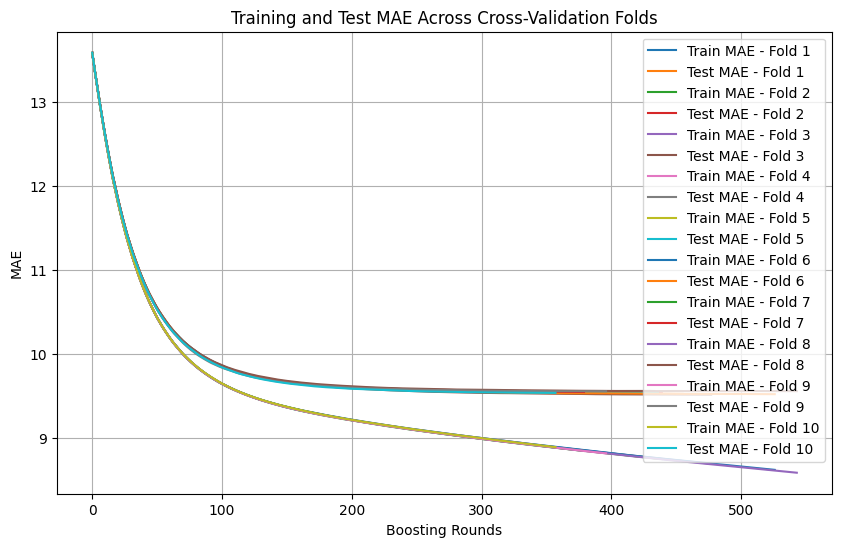

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(repeat_cv):
    plt.plot(xgb_cv[i]['train-mae-mean'], label=f'Train MAE - Fold {i+1}')
    plt.plot(xgb_cv[i]['test-mae-mean'], label=f'Test MAE - Fold {i+1}')

plt.title("Training and Test MAE Across Cross-Validation Folds")
plt.xlabel("Boosting Rounds")
plt.ylabel("MAE")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# 10 most important features (definitely need to feature engineer)

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:31:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x800 with 0 Axes>

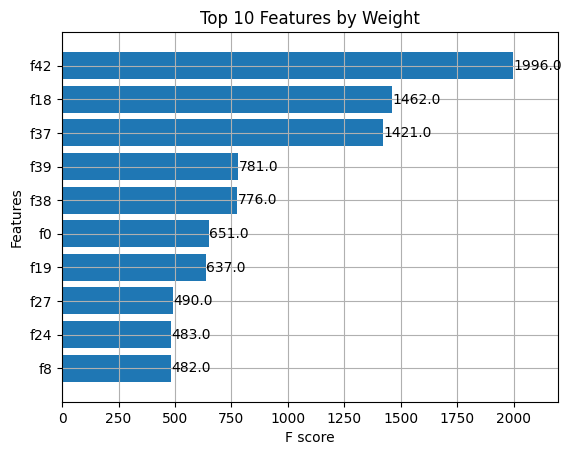

In [167]:
best_num_boost_round = xgb_cv[9].shape[0] 

model = xgb.train(param, dtrain, num_boost_round=best_num_boost_round)

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.8)
plt.title("Top 10 Features by Weight")
plt.show()


In [168]:
print("In order, the most important features are: ")
print(f"1. {features[42]}")
print(f"2. {features[18]}")
print(f"3. {features[37]}")
print(f"4. {features[38]}")
print(f"5. {features[39]}")
print(f"6. {features[19]}")
print(f"7. {features[0]}")
print(f"8. {features[8]}")
print(f"9. {features[24]}")
print(f"10. {features[27]}")

In order, the most important features are: 
1. Seed_diff
2. T1_PointDiffmean
3. T2_PointDiffmean
4. T1_seed
5. T2_seed
6. T2_FGMmean
7. T1_FGMmean
8. T1_PFmean
9. T2_Astmean
10. T2_PFmean


# Learning curve

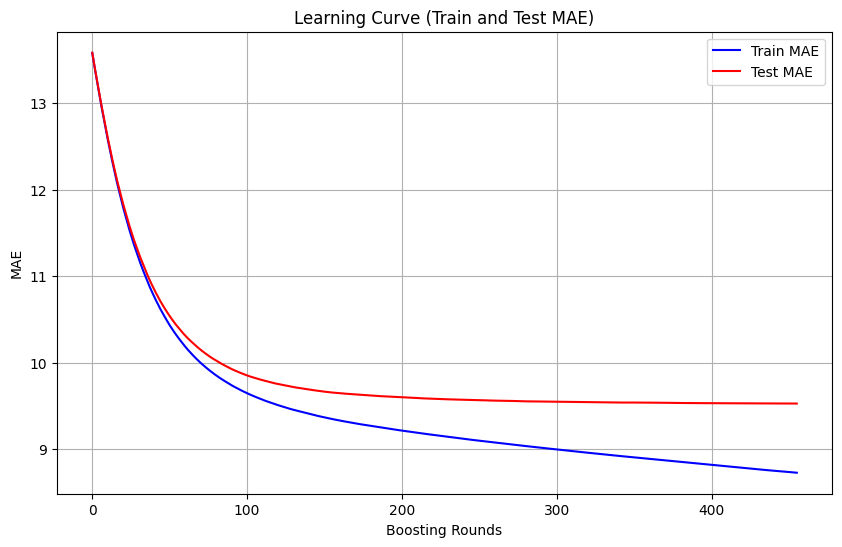

In [169]:
plt.figure(figsize=(10, 6))
plt.plot(xgb_cv[0]['train-mae-mean'], label='Train MAE', color='blue')
plt.plot(xgb_cv[0]['test-mae-mean'], label='Test MAE', color='red')
plt.title("Learning Curve (Train and Test MAE)")
plt.xlabel("Boosting Rounds")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

In [170]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]

oof_preds = []
for i in range(repeat_cv):
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:31:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_11206/2329130935.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.21301403e+01  1.30822372e+01  5.98835421e+00  2.11196575e+01
  1.04258690e+01 -1.05817306e+00  9.72347832e+00 -9.68824005e+00
 -3.97182751e+00 -8.48616719e-01 -3.61209607e+00 -1.48706591e+00
  5.85168934e+00  3.25273538e+00  1.82314415e+01  4.05372190e+00
  3.23026991e+00  4.13749456e-01 -1.60837722e+00  8.21510506e+00
  2.03027020e+01 -1.54632568e+00  3.41776156e+00  3.00014515e+01
  9.67570400e+00 -2.42806101e+00  1.84172726e+01  6.73861217e+00
  1.19968538e+01  3.44681644e+00  1.34666414e+01 -1.65322745e+00
  4.824869

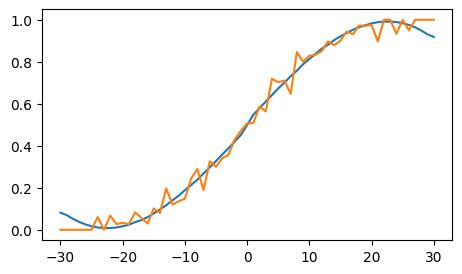

In [171]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))


plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int').mean().reset_index()

plt.figure(figsize=[5.3,3.0])
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

# Preparing output for submission

In [182]:
sampleSub2 = pd.read_csv("../../data/SampleSubmissionStage2.csv")
print(f"sampleSub2.shape: {sub.shape}")

sampleSub2['Season'] = sampleSub2['ID'].apply(lambda x: int(x.split('_')[0]))
sampleSub2["T1_TeamID"] = sampleSub2['ID'].apply(lambda x: int(x.split('_')[1]))
sampleSub2["T2_TeamID"] = sampleSub2['ID'].apply(lambda x: int(x.split('_')[2]))

print(f"season_statistics T1.shape: {season_statistics_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"season_statistics T2.shape: {season_statistics_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"glm_qualityT1.shape: {glm_quality_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"glm_qualityT2.shape: {glm_quality_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"seeds_T1.shape: {seeds_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"seeds_T2.shape: {seeds_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"last30days_stats_T1.shape: {last30days_stats_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, last30days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"last30days_stats_T2.shape: {last30days_stats_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, last30days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sampleSub2["Seed_diff"] = sampleSub2["T1_seed"] - sampleSub2["T2_seed"]

Xsub = sampleSub2[features].values
dtest = xgb.DMatrix(Xsub)


sub_models = []
for i in range(repeat_cv):
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sampleSub2["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
# sub[['ID','Pred']].to_csv("../../submissionImproved.11.2025.csv", index = None)
# sub.to_csv("../../full_col_submission.11.2025.csv", index = None)


sampleSub2.shape: (507108, 50)
season_statistics T1.shape: (13583, 21)
season_statistics T2.shape: (13583, 21)
glm_qualityT1.shape: (1682, 3)
glm_qualityT2.shape: (1682, 3)
seeds_T1.shape: (4234, 3)
seeds_T2.shape: (4234, 3)
last30days_stats_T1.shape: (13563, 3)
last30days_stats_T2.shape: (13563, 3)


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  w

In [183]:
sample_sub2_2025 = sampleSub2[
    sampleSub2["ID"].astype(str).str.startswith("2025")
]

display(sample_sub2_2025[['ID','Pred']].sample(30))

,ID,Pred
4848,2025_1115_1333,0.063006
24479,2025_1182_1212,0.139629
38031,2025_1235_1409,0.263557
129332,2025_3412_3418,0.072783
51125,2025_1300_1415,0.071232
108184,2025_3255_3478,0.265368
509,2025_1102_1257,0.056362
86650,2025_3170_3266,0.064024
63284,2025_1402_1474,0.083988
111917,2025_3274_3288,0.089385


In [184]:
sample_sub2_2025.shape

(131407, 50)

In [185]:
sample_sub2_2025.to_csv("../../submissions/stage2March14th.csv", index = None)

In [189]:
sample_sub2_2025_for_kaggle = sampleSub2[
  ["ID", "Pred"]
]
sample_sub2_2025_for_kaggle.to_csv("../../submissions/stage2March14th.csv", index = None)

In [1]:
sample_sub2_2025_for_kaggle[sample_sub2_2025_for_kaggle["Pred"] > 0.5].shape

NameError: name 'sample_sub2_2025_for_kaggle' is not defined

In [173]:
sub = pd.read_csv("../../data/SampleSubmissionStage1.csv")
print(f"sub.shape: {sub.shape}")

sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))

print(f"season_statistics T1.shape: {season_statistics_T1.shape}")
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"season_statistics T2.shape: {season_statistics_T2.shape}")
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"glm_qualityT1.shape: {glm_quality_T1.shape}")
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"glm_qualityT2.shape: {glm_quality_T2.shape}")
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"seeds_T1.shape: {seeds_T1.shape}")
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"seeds_T2.shape: {seeds_T2.shape}")
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"last30days_stats_T1.shape: {last30days_stats_T1.shape}")
sub = pd.merge(sub, last30days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"last30days_stats_T2.shape: {last30days_stats_T2.shape}")
sub = pd.merge(sub, last30days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)


sub_models = []
for i in range(repeat_cv):
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
# sub[['ID','Pred']].to_csv("../../submissionImproved.11.2025.csv", index = None)
# sub.to_csv("../../full_col_submission.11.2025.csv", index = None)


sub.shape: (507108, 2)
season_statistics T1.shape: (13583, 21)
season_statistics T2.shape: (13583, 21)
glm_qualityT1.shape: (1682, 3)
glm_qualityT2.shape: (1682, 3)
seeds_T1.shape: (4234, 3)
seeds_T2.shape: (4234, 3)
last30days_stats_T1.shape: (13563, 3)
last30days_stats_T2.shape: (13563, 3)


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:35:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:35:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:35:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:35:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  w

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
teams = pd.read_csv('../../data/MTeams.csv')  
MTeam_spellings = pd.read_csv('../../data/MTeamspellings.csv', encoding='ISO-8859-1')  
WTeam_spellings = pd.read_csv('../../data/WTeamspellings.csv', encoding='ISO-8859-1')  
teams_spelling = pd.concat([MTeam_spellings, WTeam_spellings])
teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
teams_spelling.columns = ['TeamID', 'TeamNameCount']
teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,TeamNameCount
0,1101,Abilene Chr,2014,2025,3
1,1102,Air Force,1985,2025,2
2,1103,Akron,1985,2025,1
3,1104,Alabama,1985,2025,1
4,1105,Alabama A&M,2000,2025,2


In [ ]:
merged_df = sub_2025.merge(teams, left_on="T1_TeamID", right_on="TeamID", how="left")
merged_df = merged_df.rename(columns={"TeamName": "Team1_Name"}).drop(columns=["TeamID"])


merged_df = merged_df.merge(teams, left_on="T2_TeamID", right_on="TeamID", how="left")
merged_df = merged_df.rename(columns={"TeamName": "Team2_Name"}).drop(columns=["TeamID"])

merged_df.sample(20)


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,...,T2_win_ratio_14d,Seed_diff,Team1_Name,FirstD1Season_x,LastD1Season_x,TeamNameCount_x,Team2_Name,FirstD1Season_y,LastD1Season_y,TeamNameCount_y
106613,2021_3301_3429,0.379291,2021,3301,3429,29.045455,62.272727,7.045455,19.681818,9.227273,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316425,2023_3114_3120,0.118625,2023,3114,3120,20.322581,53.000000,0.612903,4.354839,8.709677,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157032,2022_1236_1333,0.174822,2022,1236,1333,25.633333,56.666667,9.166667,25.100000,5.833333,...,0.000000,NaN,PFW,2003.0,2025.0,9.0,Oregon St,1985.0,2025.0,5.0
142254,2022_1178_1200,0.082939,2022,1178,1200,24.535714,56.428571,10.250000,27.857143,8.250000,...,0.600000,NaN,Detroit,1985.0,2025.0,3.0,Fordham,1985.0,2025.0,1.0
138324,2022_1164_1370,0.064181,2022,1164,1370,22.343750,57.843750,8.562500,28.875000,6.781250,...,0.500000,NaN,Coppin St,1986.0,2025.0,5.0,Seattle,2009.0,2025.0,3.0
13203,2021_1149_1300,0.076838,2021,1149,1300,22.250000,55.950000,7.550000,24.300000,7.600000,...,0.333333,NaN,Charleston So,1985.0,2025.0,5.0,NC Central,2008.0,2025.0,5.0
314676,2023_3108_3122,0.025000,2023,3108,3122,22.148148,60.481481,4.592593,16.481481,11.000000,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201636,2022_3164_3187,0.030513,2022,3164,3187,21.428571,59.428571,5.357143,20.357143,9.178571,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489293,2024_3280_3426,0.272073,2024,3280,3426,28.093750,62.437500,6.156250,17.406250,11.343750,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207178,2022_3183_3239,0.117397,2022,3183,3239,24.428571,59.500000,5.571429,17.571429,9.214286,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
